# DeepXDE - Bernard Cavity

In this notebook i'll be implementing the bernard cavity case. I'll be following the paper Hashemi+2024 and adding some twists to make it work better as i go.

In [1]:
# stdlib
from copy import deepcopy
from functools import reduce

# 3rth party
import fluidfoam as ff
import deepxde as dde
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Setting defaults
# dde.config.set_default_float("float64")
torch.set_default_device('cuda:1')
torch._dynamo.config.suppress_errors = True

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
torch.cuda.get_device_name()

'NVIDIA RTX A6000'

In [3]:
rho = 1
mu = 0.001
alpha = 0.005
D = 0.1
L = D
beta = 1.0
g = 9.81

T0 = 0
T_bottom = 1

S0 = (T0 - T0)/(T_bottom - T0)
S_bottom = (T_bottom - T0)/(T_bottom - T0)


assert T_bottom > T0, "For a Benard cell the bottom temperature should be higher than the rest"

Ra = g*beta*(T_bottom-T0)*D**3*rho/(alpha*mu)
Pr = mu/(rho*alpha)
print(f"{Ra = }, {Pr = }")

Ra = 1962.0000000000005, Pr = 0.2


In [4]:
def transform(X, Y):
    """Ansatz to make the spped exactly zero on the boundaries"""
    noslip_ansatz_factor = X[:, 0:1] * (L - X[:, 0:1]) * X[:, 1:2] * (D - X[:, 1:2])
    temperature_ansatz = X[:, 1:2]/D*(S0 + (D - X[:, 1:2])) + S_bottom * (D - X[:, 1:2])/D

    return torch.hstack(
        (
            noslip_ansatz_factor*Y[:, 0:2],  
            1.0 + (X[:, 0:1]**2 + X[:, 1:2]**2)**0.5*Y[:, 2:3],
            temperature_ansatz +  X[:, 1:2] * (D - X[:, 1:2])*Y[:, 3:]
        )
    )

In [22]:
net = dde.maps.FNN([2,] + [256]*6 + [4,], "silu", "Glorot uniform")

CASE = "../../tests/vizualizing_simulation_data/bernard_cell_of_v2/"

x, y, z = ff.readmesh(CASE, structured=True)

u, v, w = ff.readvector(CASE, "1000", "U", structured=True)
p = ff.readscalar(CASE, "1000", "p", structured=True)
T = ff.readscalar(CASE, "1000", "T", structured=True)

N = reduce(lambda l, r: l*r, x.shape)

N

Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/owner
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/faces
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/points
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/neighbour
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/U
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/owner
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/faces
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/points
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/neighbour
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/p
Reading file ../../tests/vizualizing_simulation_data/ber

40000

In [25]:
print(f"{u.max()} | {v.max()}")

u = u*10_000
v = v*10_000

8.96956e-05 | 0.000111811


In [26]:


X = np.hstack([x.reshape(N, 1), y.reshape(N, 1)], dtype=np.float32)
Y = np.hstack([f.reshape(N, 1) for f in (u, v, p, T)], dtype=np.float32)

X = torch.from_numpy(X).requires_grad_(True).to("cuda:1")
Y = torch.from_numpy(Y).requires_grad_(True).to("cuda:1")


batch_size = int(N*0.2)


dataset = TensorDataset(X, Y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda:1'))

In [27]:
net = dde.maps.FNN([2,] + [256]*6 + [4,], "silu", "Glorot uniform")
net.compile()
net.to("cuda:1")

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss(reduction='mean')

losses = []

In [9]:
torch.set_float32_matmul_precision('high')

In [12]:
torch._dynamo.config.suppress_errors = True

In [28]:
for epoch in range(0, 100_000):

    optimizer.zero_grad()

    for batch_X, batch_Y in data_loader:
        # Forward pass
        outputs = net(batch_X)
        loss = loss_fn(outputs, batch_Y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        net.eval()
        outputs = net.forward(X)
        loss = loss_fn(Y, outputs)
        losses.append(loss.item())
        net.train()
        
    if epoch % 1000 == 0:
        print(f"epoch={len(losses)} | loss = {loss.item()}")

        

    if loss.item() <= min(losses) and loss.item() < 0.1:
        print(f"Best loss at epoch: {len(losses)} | loss={loss.item()}. Saving model")
        net_best = deepcopy(net)

epoch=1 | loss = 22478.947265625
Best loss at epoch: 258 | loss=0.09935819357633591. Saving model
Best loss at epoch: 259 | loss=0.09525275230407715. Saving model
Best loss at epoch: 260 | loss=0.09059499204158783. Saving model
Best loss at epoch: 261 | loss=0.08897958695888519. Saving model
Best loss at epoch: 262 | loss=0.0880747139453888. Saving model
Best loss at epoch: 263 | loss=0.0851798951625824. Saving model
Best loss at epoch: 264 | loss=0.08492568880319595. Saving model
Best loss at epoch: 265 | loss=0.08305279165506363. Saving model
Best loss at epoch: 266 | loss=0.0806359201669693. Saving model
Best loss at epoch: 267 | loss=0.08008480072021484. Saving model
Best loss at epoch: 268 | loss=0.0788176953792572. Saving model
Best loss at epoch: 269 | loss=0.07817521691322327. Saving model
Best loss at epoch: 271 | loss=0.07670644670724869. Saving model
Best loss at epoch: 272 | loss=0.07636560499668121. Saving model
Best loss at epoch: 275 | loss=0.07619675248861313. Saving mo

KeyboardInterrupt: 

In [ ]:
torch.all(next(net_best.parameters()) == next(net.parameters()))

In [29]:
with torch.no_grad():
    Y_test = net.forward(X)
    Y_test_best = net_best.forward(X)

In [ ]:
x.shape[:2]

In [61]:
U.ravel()

tensor([-0.1451, -0.1725, -0.2483,  ...,  0.0058,  0.0048,  0.0075],
       device='cuda:1')

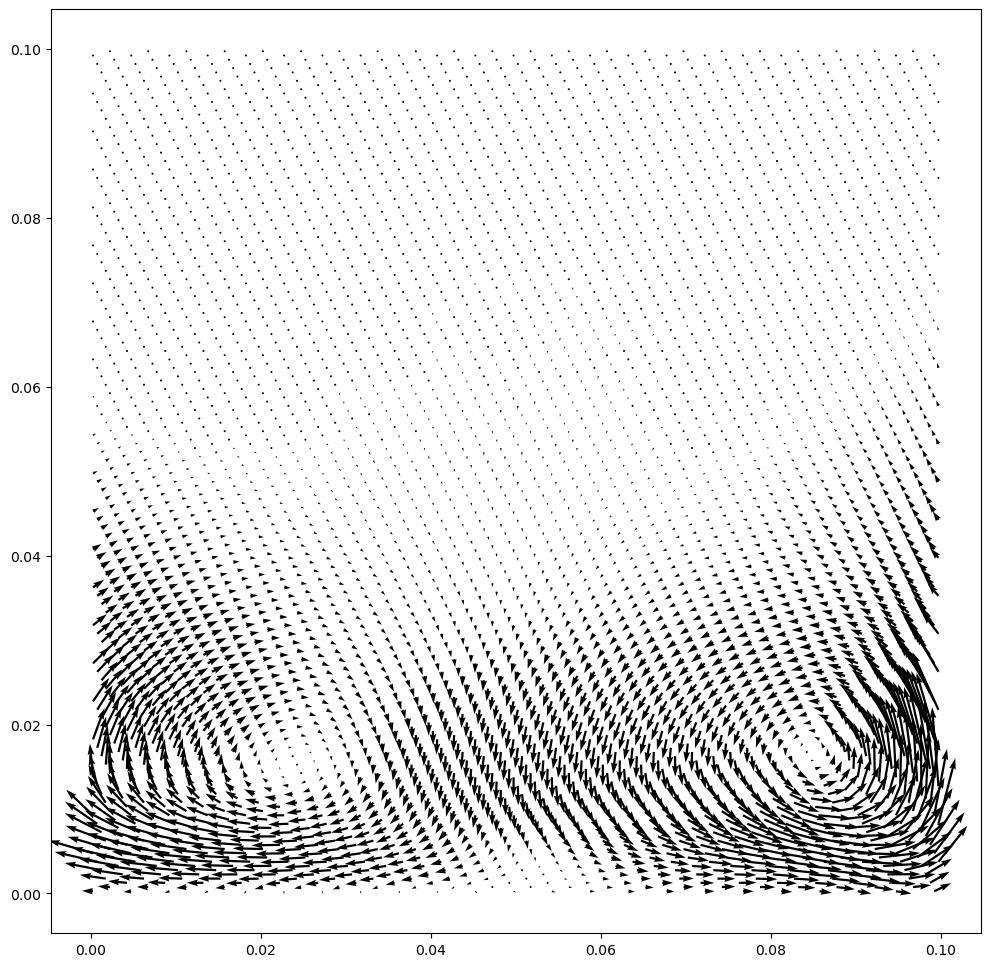

In [70]:
U, V = Y_test_best[:, :2].T

U = U.reshape(*x.shape[:2])
V = V.reshape(*x.shape[:2])

S = (U**2 + V**2)**0.5

fig, ax = plt.subplots(
    figsize=(12, 12)
)


skip=9
ax.quiver(x.ravel()[::skip], y.ravel()[::skip], U.ravel()[::skip].to("cpu")/10_000, V.ravel()[::skip].to("cpu")/10_000)

# plt.scatter(x, y, c=S.cpu(), alpha=0.25)

In [78]:
((U.to("cpu") - u)**2).mean()

tensor(0.0317, dtype=torch.float64)

In [47]:
U.shape

torch.Size([200, 200])